### Entendimento do Problema

Prever qual cliente pode deixar a compania baseado nos dados fornecidos, para criar e aplicar de forma assertiva programas de retenção.

### Entendimento dos dados

Os dados fornecidos indicam os serviços contratados por cada cliente, seu contexto social/familiar, a quanto tempo é cliente, a quantia gasta com a compania e se ele deixou a compania no último mês.

### Preparação dos dados

Imports

In [275]:
import numpy as np;
import pandas as pd;
import os;
import matplotlib.pyplot as plt;
from sklearn import preprocessing;
from sklearn import tree;
from sklearn.model_selection import train_test_split;
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay;
from sklearn.metrics import plot_confusion_matrix;
from sklearn.metrics import accuracy_score;
from xgboost import XGBClassifier;
import tensorflow as tf;

Constantes

In [2]:
rootpath = 'D:\\Felipe\\i2a2\\challenges\\final - telco customer\\';
filepath = rootpath + 'WA_Fn-UseC_-Telco-Customer-Churn.csv';

In [3]:
pd.options.display.float_format = "{:.2f}".format;
df = pd.read_csv(filepath);
df = df[df['MonthlyCharges'] != " "];
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], downcast="float")
df = df[df['TotalCharges'] != " "];
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], downcast="float")

In [4]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


#### Plot das variaveis categoricas em relacao ao churn

In [5]:
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'];
categorical_features_no_churn = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'];

In [6]:
def plotByLabel(feature, name = '', churn_value = 'Yes', labels = None):    
    y = [];
    x = [];
    if labels is None:
        labels = feature.unique();
    for i in range(0, len(labels)):
        x.append(name+': '+labels[i]);
    for label in labels:
        y.append( len(df.loc[(feature == label) & (df['Churn'] == churn_value)]) );
    plt.bar(x, y, width=0.08);

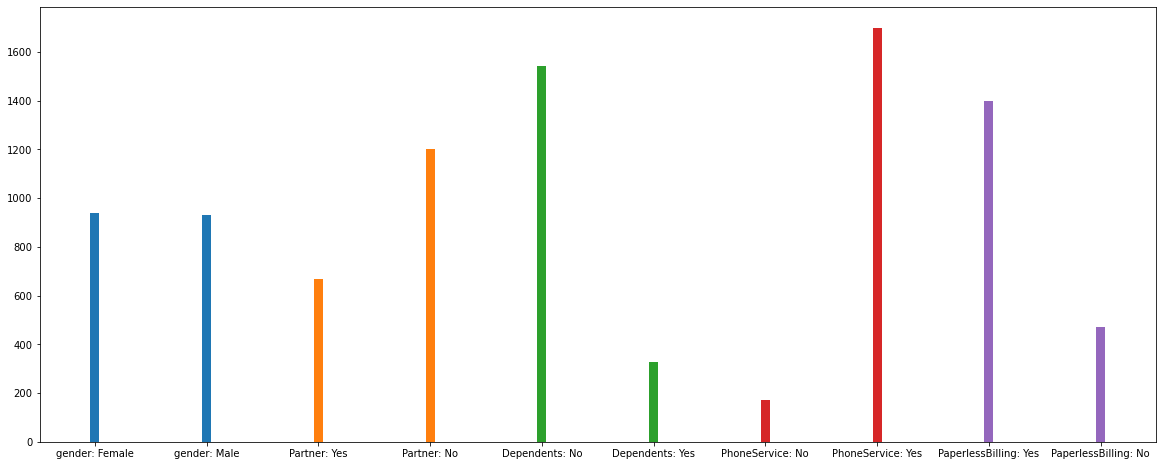

In [169]:
plt.figure(figsize=(20, 8))
for x in categorical_features_no_churn[:5]:
        plotByLabel(df[x], x);

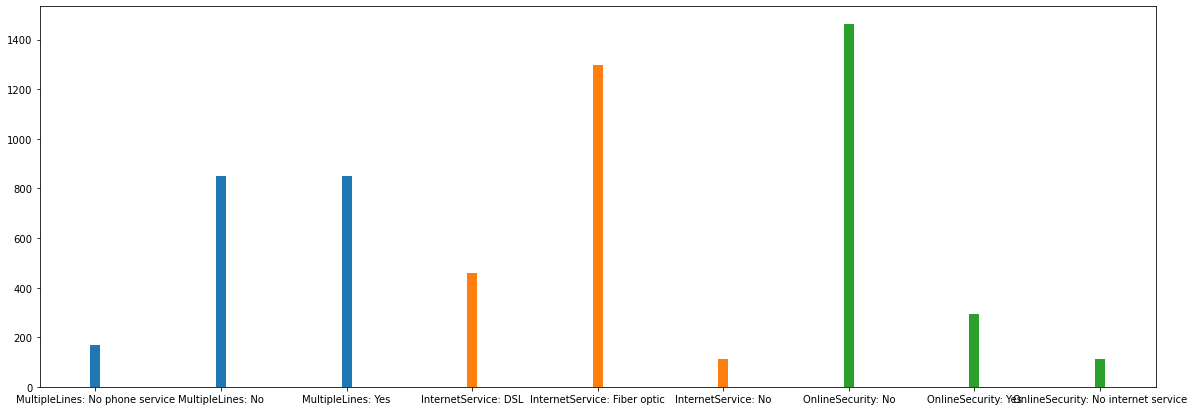

In [193]:
plt.figure(figsize=(20, 7))
for x in categorical_features_no_churn[5:8]:
        plotByLabel(df[x], x);

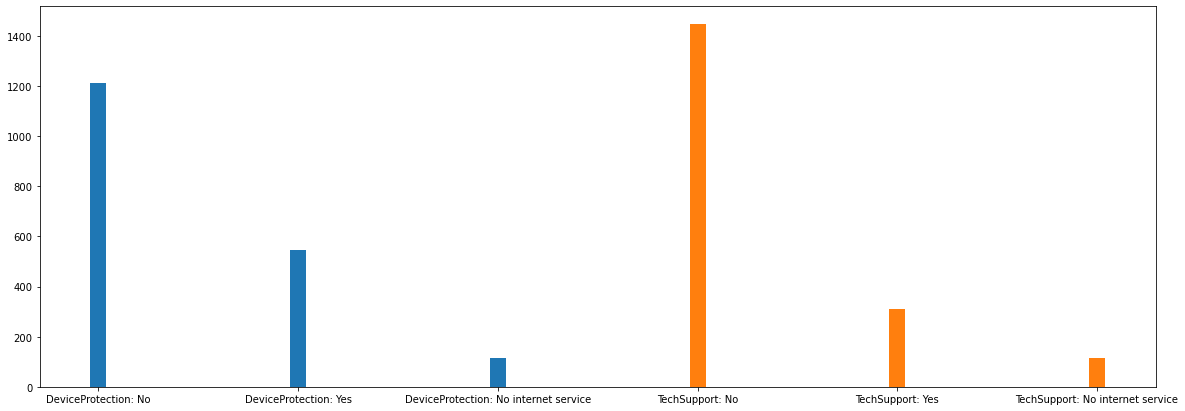

In [194]:
plt.figure(figsize=(20, 7))
for x in categorical_features_no_churn[8:10]:
        plotByLabel(df[x], x);

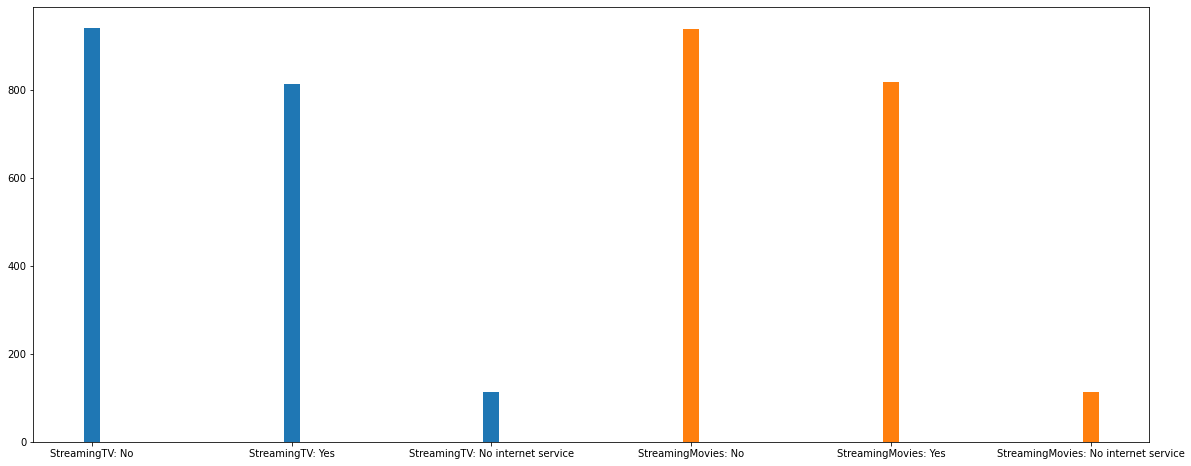

In [174]:
plt.figure(figsize=(20, 8))
for x in categorical_features_no_churn[10:12]:
        plotByLabel(df[x], x);

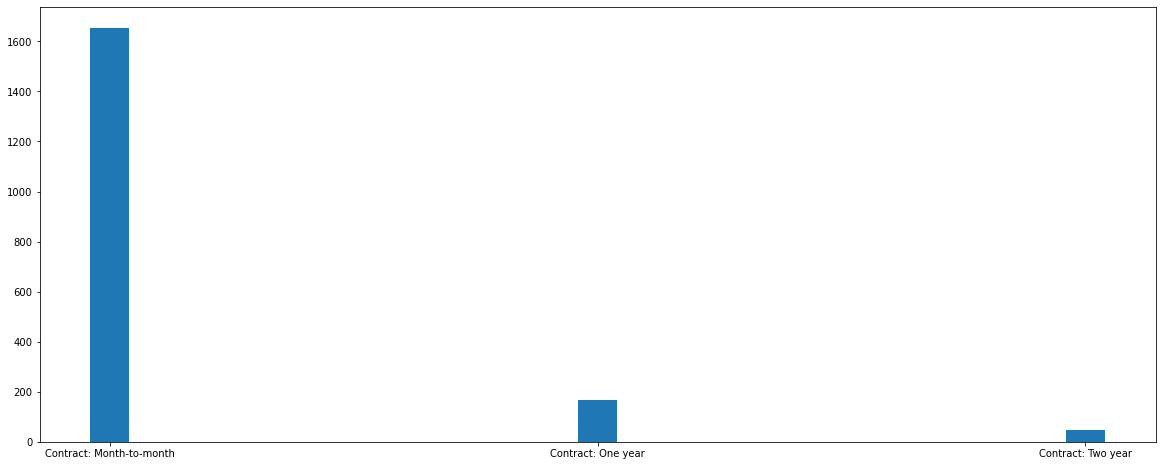

In [178]:
plt.figure(figsize=(20, 8))
for x in categorical_features_no_churn[12:13]:
        plotByLabel(df[x], x);

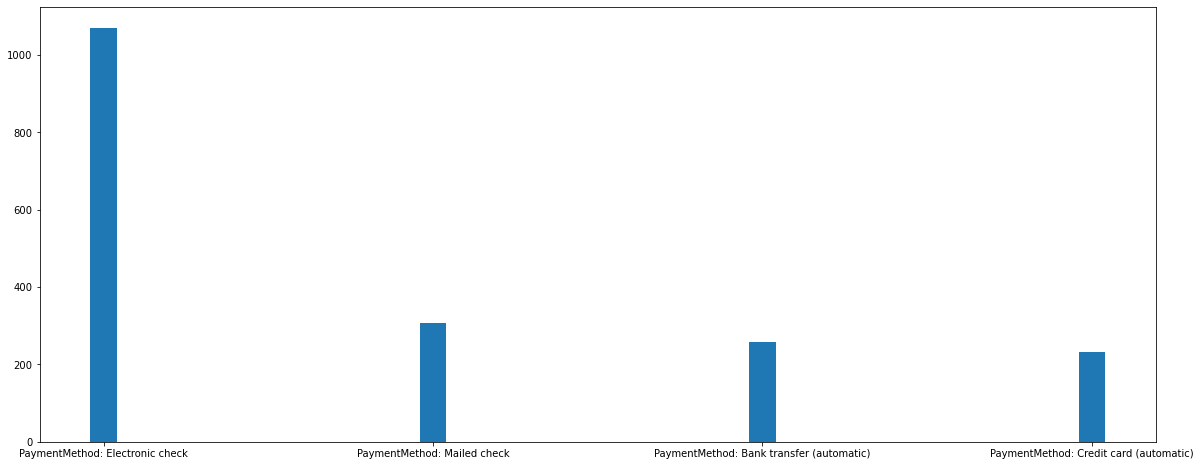

In [184]:
plt.figure(figsize=(20, 8))
for x in categorical_features_no_churn[13:14]:
        plotByLabel(df[x], x);

#### Remocao de features desnecessarias

In [7]:
df.drop(labels='customerID', axis=1, inplace=True);

#### Definição de encoders para features categóricas

In [8]:
#gender
le_gender = preprocessing.LabelEncoder();
le_gender.fit(df['gender'].unique());
#Partner
#Dependents
#PhoneService
#PaperlessBilling
#Churn
le_yesNo = preprocessing.LabelEncoder();
le_yesNo.fit(df['Partner'].unique());
#MultipleLines
le_multipleLines = preprocessing.LabelEncoder();
le_multipleLines.fit(df['MultipleLines'].unique());
#InternetService
le_internetService = preprocessing.LabelEncoder();
le_internetService.fit(df['InternetService'].unique());
#OnlineSecurity
#DeviceProtection
#TechSupport
#StreamingTV
#StreamingMovies
#OnlineBackup
le_onlineSecurity = preprocessing.LabelEncoder();
le_onlineSecurity.fit(df['OnlineSecurity'].unique());
#Contract
le_contract = preprocessing.LabelEncoder();
le_contract.fit(df['Contract'].unique());
#PaymentMethod
le_paymentMethod = preprocessing.LabelEncoder();
le_paymentMethod.fit(df['PaymentMethod'].unique());

Aplicação dos encoders

In [9]:
df['gender'] = le_gender.transform(df['gender']);

df['Partner'] = le_yesNo.transform(df['Partner']);
df['Dependents'] = le_yesNo.transform(df['Dependents']);
df['PhoneService'] = le_yesNo.transform(df['PhoneService']);
df['PaperlessBilling'] = le_yesNo.transform(df['PaperlessBilling']);
df['Churn'] = le_yesNo.transform(df['Churn']);

df['MultipleLines'] = le_multipleLines.transform(df['MultipleLines']);

df['InternetService'] = le_internetService.transform(df['InternetService']);

df['OnlineSecurity'] = le_onlineSecurity.transform(df['OnlineSecurity']);
df['DeviceProtection'] = le_onlineSecurity.transform(df['DeviceProtection']);
df['TechSupport'] = le_onlineSecurity.transform(df['TechSupport']);
df['StreamingTV'] = le_onlineSecurity.transform(df['StreamingTV']);
df['StreamingMovies'] = le_onlineSecurity.transform(df['StreamingMovies']);
df['OnlineBackup'] = le_onlineSecurity.transform(df['OnlineBackup']);

df['Contract'] = le_contract.transform(df['Contract']);

df['PaymentMethod'] = le_paymentMethod.transform(df['PaymentMethod']);

### Plot das variaveis numéricas

In [10]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges'];

In [11]:
tenure_bp = [0, 2, 4] + [x * 8 for x in range(1, 10)];
monthly_charges_bp = [0, 20] + [x * 8 for x in range(4, 15)];
total_charges_bp = [0, 150] + [x * 350 for x in range(1, 10)] + [x * 1000 for x in range(4, 9)];

In [12]:
def breakpointsDict(breakpoints):
    _dict = {};
    i = 0;
    while i < len(breakpoints) -1:
        _min = breakpoints[i];
        _max = breakpoints[i+1];
        key = '['+str(_min)+' - '+str(_max)+'[';
        value = lambda x, _min=_min, _max=_max: True if (x >= _min) & (x < _max) else False;
        _dict[key] = value;
        i = i + 1;
        
    _min = breakpoints[i];
    key = '[ >= '+str(_min)+']';
    value = lambda x, _min=_min: True if x >=_min else False;
    _dict[key] = value;
    return _dict;

def applyBreakpointsGen(_dict):
    def applyBreakpoint(val):
        for k in _dict:
            if(_dict[k](val)):
                return k;
    return applyBreakpoint;

In [13]:
segmentation_dict = breakpointsDict(monthly_charges_bp);

In [14]:
for k in segmentation_dict:
    _seg = df['MonthlyCharges'].apply(segmentation_dict[k]);
    _count = len(df[_seg.to_numpy()]);
    print(k + ': '+ str(_count))

[0 - 20[: 611
[20 - 32[: 1073
[32 - 40[: 147
[40 - 48[: 318
[48 - 56[: 570
[56 - 64[: 337
[64 - 72[: 589
[72 - 80[: 711
[80 - 88[: 723
[88 - 96[: 767
[96 - 104[: 554
[104 - 112[: 504
[ >= 112]: 128


In [15]:
tenure_dict = breakpointsDict(tenure_bp);
monthly_dict = breakpointsDict(monthly_charges_bp);
total_dict = breakpointsDict(total_charges_bp);

In [16]:
df['tenure'] = df['tenure'].apply(applyBreakpointsGen(tenure_dict));
df['MonthlyCharges'] = df['MonthlyCharges'].apply(applyBreakpointsGen(monthly_dict));
df['TotalCharges'] = df['TotalCharges'].apply(applyBreakpointsGen(total_dict));

In [17]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,[0 - 2[,0,1,0,0,2,0,0,0,0,0,1,2,[20 - 32[,[0 - 150[,0
1,1,0,0,0,[32 - 40[,1,0,0,2,0,2,0,0,0,1,0,3,[56 - 64[,[1750 - 2100[,0
2,1,0,0,0,[2 - 4[,1,0,0,2,2,0,0,0,0,0,1,3,[48 - 56[,[0 - 150[,1
3,1,0,0,0,[40 - 48[,0,1,0,2,0,2,2,0,0,1,0,0,[40 - 48[,[1750 - 2100[,0
4,0,0,0,0,[2 - 4[,1,0,1,0,0,0,0,0,0,0,1,2,[64 - 72[,[150 - 350[,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,[24 - 32[,1,2,0,2,0,2,2,2,2,1,1,3,[80 - 88[,[1750 - 2100[,0
7039,0,0,1,1,[ >= 72],1,2,1,0,2,2,0,2,2,1,1,1,[96 - 104[,[7000 - 8000[,0
7040,0,0,1,1,[8 - 16[,0,1,0,2,0,0,0,0,0,0,1,2,[20 - 32[,[150 - 350[,0
7041,1,1,1,0,[4 - 8[,1,2,1,0,0,0,0,0,0,0,1,3,[72 - 80[,[150 - 350[,1


#### Plot das variveis numericas separadas por intervalos

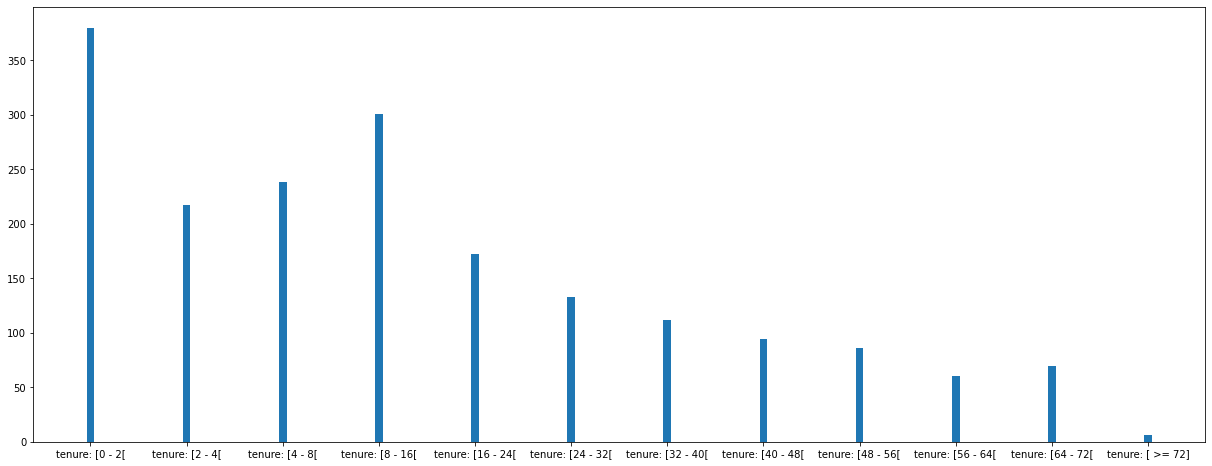

In [444]:
plt.figure(figsize=(21, 8))
plotByLabel(df[numeric_features[0]], numeric_features[0], 1, list(tenure_dict.keys()));

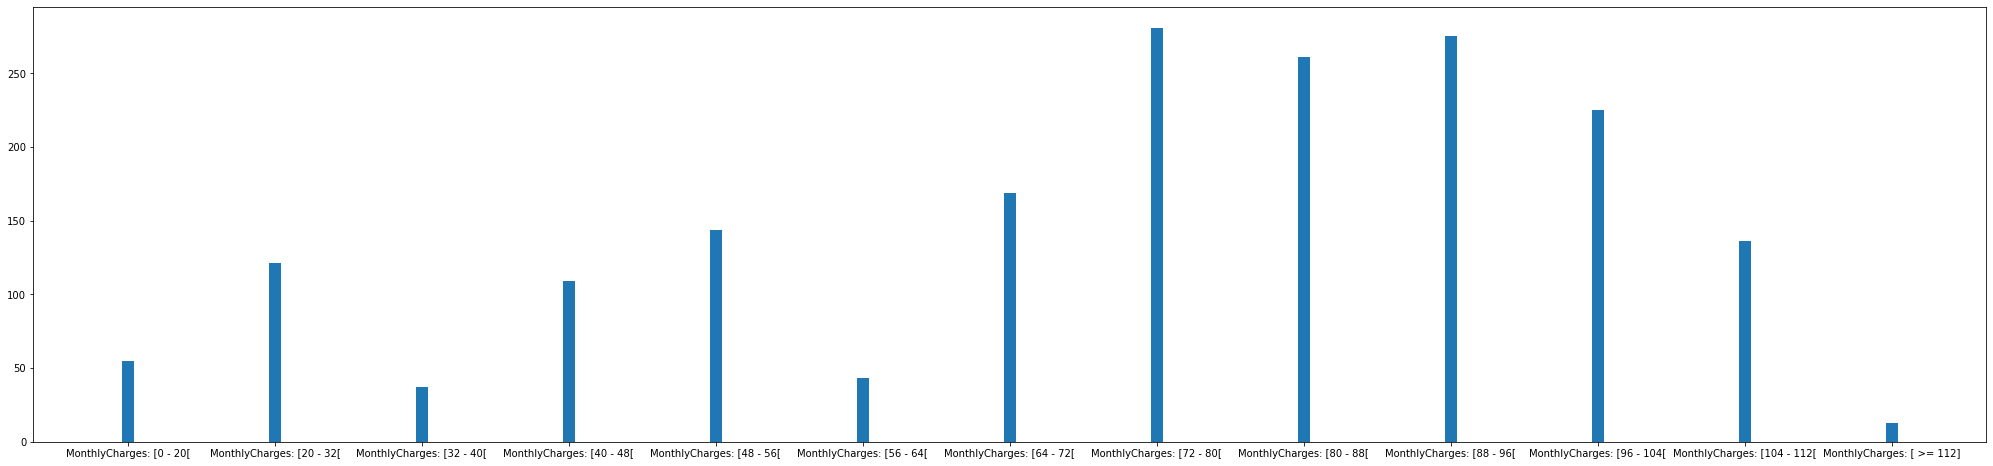

In [446]:
plt.figure(figsize=(35, 8))
plotByLabel(df[numeric_features[1]], numeric_features[1], 1, list(monthly_dict.keys()));

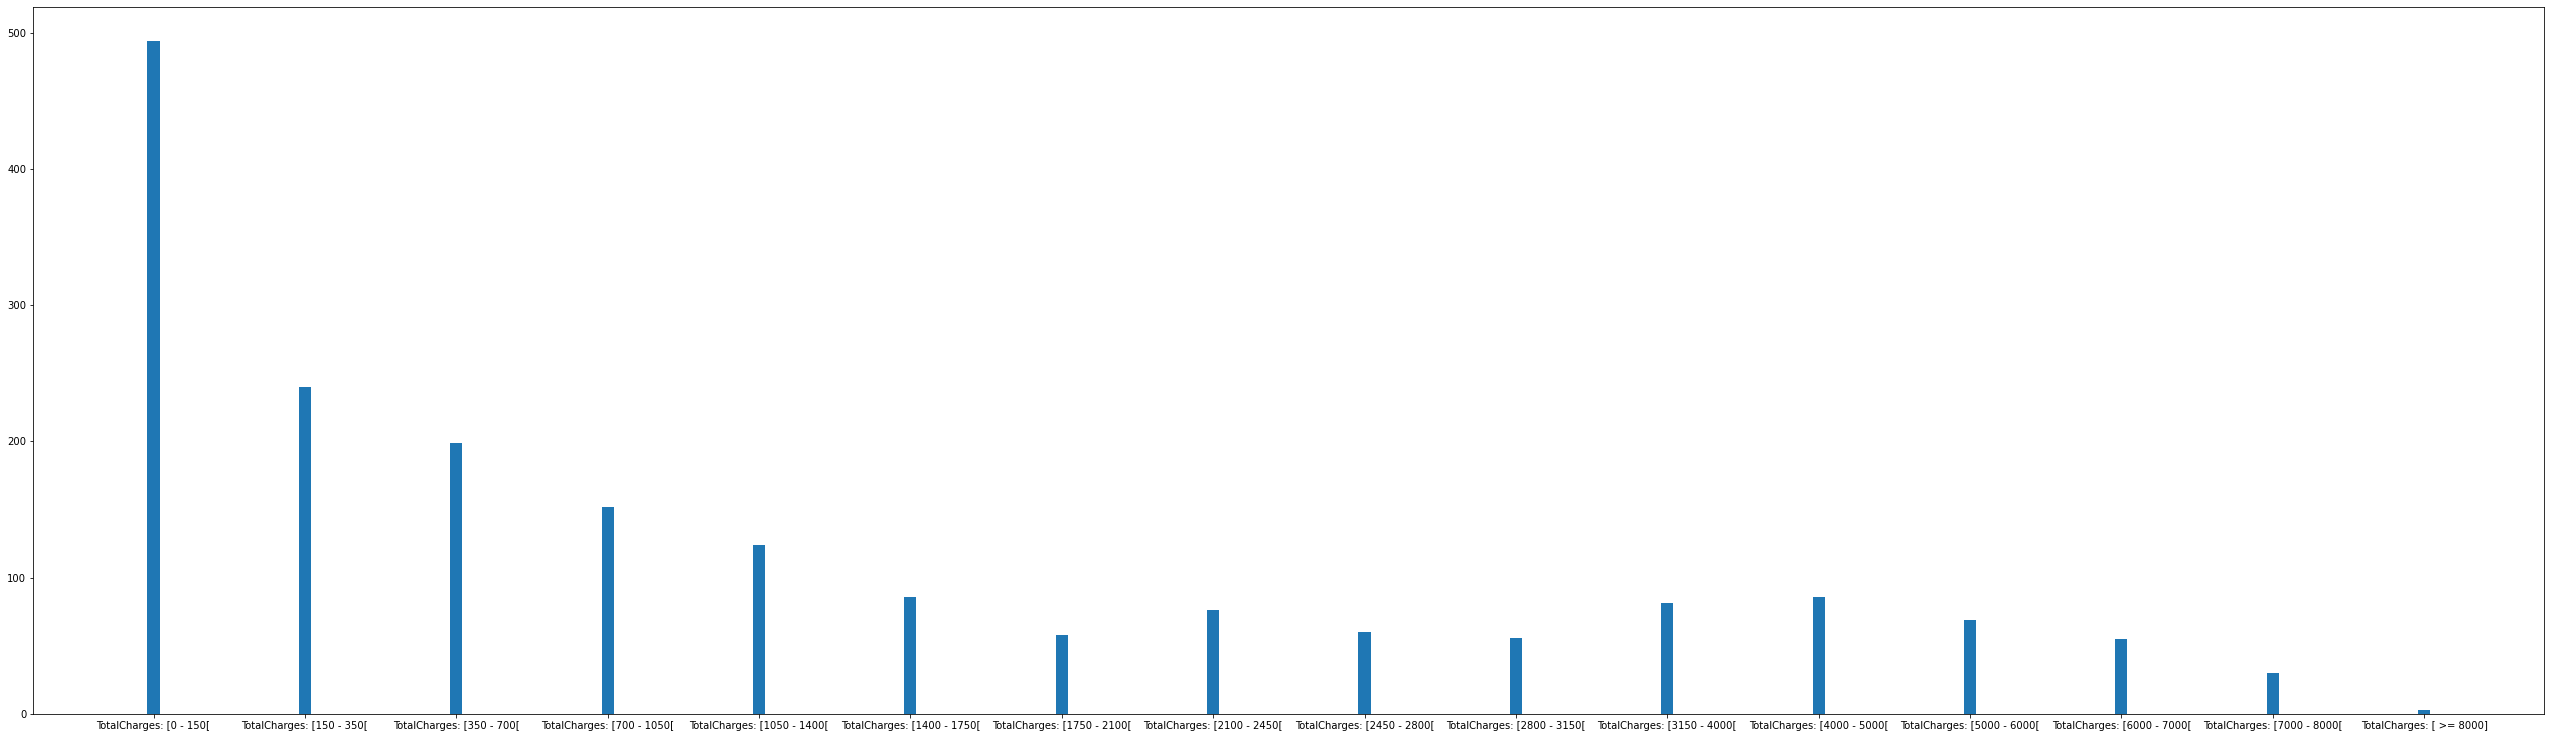

In [449]:
plt.figure(figsize=(45, 13))
plotByLabel(df[numeric_features[2]], numeric_features[2], 1, list(total_dict.keys()));

#### Encode como categoria em relação ao intervalo

In [401]:
list(tenure_dict.keys())

['[0 - 2[',
 '[2 - 4[',
 '[4 - 8[',
 '[8 - 16[',
 '[16 - 24[',
 '[24 - 32[',
 '[32 - 40[',
 '[40 - 48[',
 '[48 - 56[',
 '[56 - 64[',
 '[64 - 72[',
 '[ >= 72]']

In [402]:
len(np.array(list(tenure_dict.keys())))

12

In [18]:
le_tenure = preprocessing.LabelEncoder();
le_tenure.fit(np.array((list(tenure_dict.keys()))));
le_monthly = preprocessing.LabelEncoder();
le_monthly.fit(np.array(list(monthly_dict.keys())));
le_total = preprocessing.LabelEncoder();
le_total.fit(np.array(list(total_dict.keys())));

In [19]:
df['tenure'] = le_tenure.transform(df['tenure']);
df['MonthlyCharges'] = le_monthly.transform(df['MonthlyCharges']);
df['TotalCharges'] = le_total.transform(df['TotalCharges']);

In [20]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,3,1,0
1,1,0,0,0,5,1,0,0,2,0,2,0,0,0,1,0,3,7,5,0
2,1,0,0,0,3,1,0,0,2,2,0,0,0,0,0,1,3,6,1,1
3,1,0,0,0,7,0,1,0,2,0,2,2,0,0,1,0,0,5,5,0
4,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0,1,2,8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,4,1,2,0,2,0,2,2,2,2,1,1,3,10,5,0
7039,0,0,1,1,0,1,2,1,0,2,2,0,2,2,1,1,1,12,15,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,3,4,0
7041,1,1,1,0,6,1,2,1,0,0,0,0,0,0,0,1,3,9,4,1


### Modelagem

Separando entradas e saidas

In [21]:
y = df['Churn'].to_numpy();
x = df.drop(labels='Churn', axis=1).to_numpy();
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47);

##### Decision Tree

In [22]:
tree_model = tree.DecisionTreeClassifier();
tree_model = tree_model.fit(x_train, y_train);

#### XGBoost

In [268]:
xgb_model = XGBClassifier(max_depth=3, use_label_encoder=False, eval_metric='error');
xgb_model.fit(x_train, y_train);

#### Neural Network

In [203]:
nn_model = tf.keras.Sequential();
nn_model.add(tf.keras.layers.Dense(19, input_dim=19));
nn_model.add(tf.keras.layers.Dense(8, activation="tanh"));
nn_model.add(tf.keras.layers.Dense(32, activation="tanh"));
nn_model.add(tf.keras.layers.Dense(12, activation="relu"));
nn_model.add(tf.keras.layers.Dense(1, activation="sigmoid"));
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']);

### Avaliação

##### Decision Tree

In [239]:
y_pred = tree_model.predict(x_test);

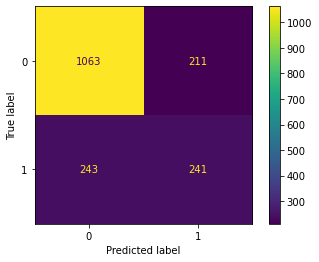

In [240]:
confusion_mat = confusion_matrix(y_test, y_pred);
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=tree_model.classes_);
cmd.plot()

In [241]:
accuracy_score(y_test, y_pred)

0.7417519908987485

#### XGBoost

In [271]:
y_pred = xgb_model.predict(x_test);

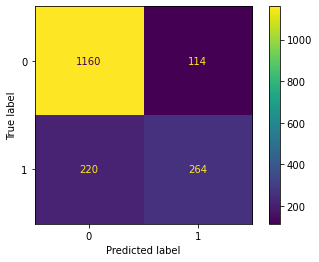

In [272]:
confusion_mat = confusion_matrix(y_test, y_pred);
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0, 1]);
cmd.plot()

In [273]:
accuracy_score(y_test, y_pred)

0.8100113765642776

#### Neural Network

In [176]:
scaler = preprocessing.MinMaxScaler();

In [204]:
s_x_train, s_x_test, s_y_train, s_y_test = train_test_split(scaler.fit_transform(x), y, test_size=0.25, random_state=47);

In [205]:
nn_model.fit(s_x_train, s_y_train, epochs=6, batch_size=110);

Epoch 1/6
48/48 [==============================] - 0s 604us/step - loss: 0.5772 - accuracy: 0.7201
Epoch 2/6
48/48 [==============================] - 0s 583us/step - loss: 0.5106 - accuracy: 0.7486
Epoch 3/6
48/48 [==============================] - 0s 610us/step - loss: 0.4800 - accuracy: 0.7692
Epoch 4/6
48/48 [==============================] - 0s 583us/step - loss: 0.4671 - accuracy: 0.7768
Epoch 5/6
48/48 [==============================] - 0s 583us/step - loss: 0.4597 - accuracy: 0.7795
Epoch 6/6
48/48 [==============================] - 0s 584us/step - loss: 0.4542 - accuracy: 0.7863


In [206]:
s_y_pred = (nn_model.predict(s_x_test) > 0.5).astype('int32');

In [207]:
s_y_pred = np.concatenate(s_y_pred, axis=0);

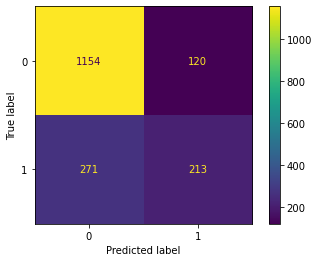

In [208]:
confusion_mat = confusion_matrix(s_y_test, s_y_pred);
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0, 1]);
cmd.plot()

In [209]:
accuracy_score(s_y_test, s_y_pred)

0.7775881683731513